In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [60]:
n = 128
m = 64
sigma = 0.1
p = 0.05
num_itr = 40
adam_lr = 3e-4
K = 200
max_inner = 20

A = np.random.randn(m, n)
eig, _ = LA.eig(A.T @ A)
gamma_opt = float(1./max(eig).real)
A = jnp.array(A)

In [61]:
def mini_batch(K):
    seq = np.random.randn(n, K)
    support = np.random.binomial(1,p,size=(n, K))
    x = jnp.array(seq * support)
    y = A @ x + sigma * jnp.array(np.random.randn(m, K))
    return y, x

In [62]:
def resample(D, K, dataset_y, dataset_x):
    x = jnp.zeros((n, K))
    y = jnp.zeros((m, K))
    for j in range(K):
        r = np.random.randint(D)
        x = x.at[:, j].set(dataset_x[:, r])
        y = y.at[:, j].set(dataset_y[:, r])
        return y, x

In [63]:
def softshrink(x, lam):
    return jnp.sign(x) * jnp.max(jnp.append(jnp.abs(x) - lam, 0))
vec_softshrink = jax.jit(jax.vmap(softshrink, in_axes=[-1, None], out_axes=-1))

In [64]:
def ISTA(max_itr, y):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= gamma_opt * A.T @ (A@x - y)
        x = vec_softshrink(x.reshape(1, -1), gamma_opt)
        x = x.reshape(n, K)
    return x

In [65]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [66]:
def comp_mse(max_itr):
    y, x_org = mini_batch(K)
    x_hat = ISTA(max_itr, y)
    return jnp.sum(batch_get_dot(x_org - x_hat))/K

In [67]:
ISTA_mse = [float(jax.device_get(comp_mse(i+1)).real) for i in range(num_itr)]
df = pd.DataFrame()
df["Itaration"] = range(num_itr)
df["ISTA (fixed step size)"] = ISTA_mse

In [68]:
@partial(jax.jit, static_argnums=0)
def DU_ISTA(max_itr, y, eta, mu):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= eta[i] * A.T@(A@x -y)
        x = vec_softshrink(x.reshape(1, -1), mu[i])
        x = x.reshape((n, K)).real
    return x

In [69]:
@partial(jax.jit, static_argnums=1)
def loss(x_org, max_itr, y, eta, mu):
    x_hat = DU_ISTA(max_itr, y, eta, mu)
    return jnp.sum(batch_get_dot(x_org - x_hat))/K

In [70]:
def comp_mse_DUGD(max_itr, eta, mu):
    y, x_org = mini_batch(K)
    return float(loss(x_org, max_itr, y, eta, mu))

In [71]:
opt_init1, opt_update1, get_params1 = optimizers.adam(adam_lr)
opt_init2, opt_update2, get_params2 = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(x_org, max_itr, y, step_num, opt_state1, opt_state2):
    tmp_eta = get_params1(opt_state1)
    tmp_mu = get_params2(opt_state2)
    value, grads = jax.value_and_grad(loss, argnums=-2)(x_org, max_itr, y, tmp_eta, tmp_mu)
    new_opt_state1 = opt_update1(step_num, grads, opt_state1)
    value, grads = jax.value_and_grad(loss, argnums=-1)(x_org, max_itr, y, tmp_eta, tmp_mu)
    new_opt_state2 = opt_update2(step_num, grads, opt_state2)
    return value, new_opt_state1, new_opt_state2

def train(eta, mu, dataset_y, dataset_x, K, D):
    opt_state1 = opt_init1(eta)
    opt_state2 = opt_init2(mu)
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            y, x_org = resample(D, K, dataset_y, dataset_x)
            value, opt_state1, opt_state2 = step(x_org, itr+1, y, i, opt_state1, opt_state2)
        loss = comp_mse_DUGD(itr, get_params1(opt_state1), get_params2(opt_state2))
        print("\r"+"\rloss:{}".format(loss), end=" ")
    return get_params1(opt_state1), get_params2(opt_state2)

In [72]:
D = 10
dataset_y, dataset_x = mini_batch(D)

In [73]:
eta_init = gamma_opt*jnp.ones(num_itr)
mu_init = gamma_opt*jnp.ones(num_itr)

eta_trained, mu_trained = train(eta_init, mu_init, dataset_y, dataset_x, K, D)

  0%|          | 0/40 [00:00<?, ?it/s]

loss:60088727371776.0  4 

In [74]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, mu_trained) for i in range(num_itr)]
df["DU-ISTA D={}".format(D)] = DUGD_mse

In [84]:
adam_lr = 1e-4
D = 50
dataset_y, dataset_x = mini_batch(D)
opt_init1, opt_update1, get_params1 = optimizers.adam(adam_lr)
opt_init2, opt_update2, get_params2 = optimizers.adam(adam_lr)

In [85]:
eta_trained, mu_trained = train(eta_init, mu_init, dataset_y, dataset_x, K, D)

  0%|          | 0/40 [00:00<?, ?it/s]

loss:0.10093618929386139 

In [86]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, mu_trained) for i in range(num_itr)]
df["DU-ISTA D={}".format(D)] = DUGD_mse

In [77]:
adam_lr = 1e-4
D = 100
dataset_y, dataset_x = mini_batch(D)
opt_init1, opt_update1, get_params1 = optimizers.adam(adam_lr)
opt_init2, opt_update2, get_params2 = optimizers.adam(adam_lr)

In [78]:
eta_trained, mu_trained = train(eta_init, mu_init, dataset_y, dataset_x, K, D)

  0%|          | 0/40 [00:00<?, ?it/s]

loss:0.1257309913635254  

In [79]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, mu_trained) for i in range(num_itr)]
df["DU-ISTA D={}".format(D)] = DUGD_mse

In [87]:
adam_lr = 1e-4
D = 5000
dataset_y, dataset_x = mini_batch(D)
opt_init1, opt_update1, get_params1 = optimizers.adam(adam_lr)
opt_init2, opt_update2, get_params2 = optimizers.adam(adam_lr)

In [88]:
eta_trained, mu_trained = train(eta_init, mu_init, dataset_y, dataset_x, K, D)

  0%|          | 0/40 [00:00<?, ?it/s]

loss:0.0876668319106102  

In [89]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, mu_trained) for i in range(num_itr)]
df["DU-ISTA D={}".format(D)] = DUGD_mse

(0.02, 100)

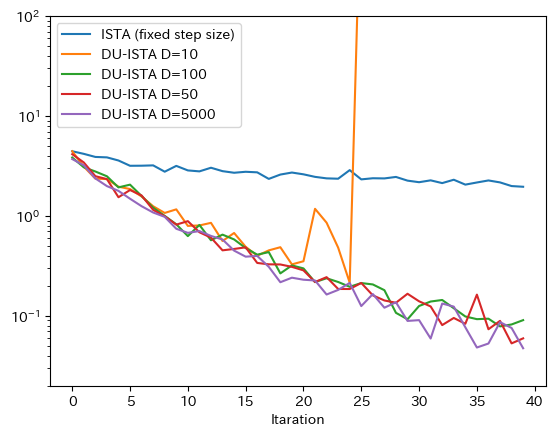

In [96]:
df.plot(df.columns[0], df.columns[1:6])
plt.yscale("log")
plt.ylim([0.02, 100])